<a href="https://colab.research.google.com/github/RogerioSFFilho/RogerioSFFilho/blob/main/Comparacao_Memoria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install memory_profiler

**IMPORTANDO AS BIBLIOTECAS**

In [2]:
import pandas as pd
import polars as pl
import duckdb
import time
import kagglehub
import psutil
import multiprocessing as mp
from memory_profiler import memory_usage
import os

In [3]:
path = kagglehub.dataset_download("microize/newyork-yellow-taxi-trip-data-2020-2019")
LOCAL = f'{path}/yellow_tripdata_2020-04.csv'

100%|██████████| 1.81G/1.81G [01:30<00:00, 21.4MB/s]

Extracting files...


In [4]:
def teste_pandas():
    start_time = time.time()
    df = pd.read_csv(LOCAL, parse_dates=['tpep_pickup_datetime'])
    df = df[df['tip_amount'] > 0]
    df['hour'] = df['tpep_pickup_datetime'].dt.hour
    result = df.groupby('hour')['tip_amount'].mean().reset_index()
    result.to_parquet("pandas.parquet")
    elapsed = time.time() - start_time
    return result, elapsed

def teste_polars():
    start_time = time.time()

    df = pl.read_csv(LOCAL)
    df = df.with_columns(
        pl.col('tpep_pickup_datetime').str.strptime(pl.Datetime, format="%Y-%m-%d %H:%M:%S")
    )
    df = df.filter(pl.col('tip_amount') > 0)
    df = df.with_columns(
        pl.col('tpep_pickup_datetime').dt.hour().alias('hour')
    )
    result = df.group_by('hour').agg(
        pl.col('tip_amount').mean().alias('mean_tip_amount')
    )
    result.write_parquet("polars_result.parquet")

    elapsed = time.time() - start_time
    return result, elapsed

def teste_duckdb():
    start_time = time.time()

    con = duckdb.connect()
    query = f"""
    SELECT EXTRACT('hour' FROM tpep_pickup_datetime) AS hour, AVG(tip_amount) AS mean_tip_amount
    FROM read_csv_auto('{LOCAL}')
    WHERE tip_amount > 0
    GROUP BY hour
    ORDER BY hour
    """
    result = con.execute(query).df()
    result.to_parquet("duckdb_result.parquet")

    elapsed = time.time() - start_time
    return result, elapsed

def run_with_memory(func, name):
    mem_usage, result = memory_usage((func,), retval=True)
    peak_mem = max(mem_usage)
    return result[1], peak_mem

In [5]:
def medir_performance(func):
    def wrapper(queue):
        process = psutil.Process(os.getpid())
        mem_inicio = process.memory_info().rss / (1024 ** 2)
        tempo_inicio = time.time()

        func()

        tempo_fim = time.time()
        mem_fim = process.memory_info().rss / (1024 ** 2)

        tempo = tempo_fim - tempo_inicio
        memoria = mem_fim - mem_inicio
        queue.put((tempo, memoria))
    return wrapper

In [6]:
def executar_teste(nome, func):
    queue = mp.Queue()
    processo = mp.Process(target=medir_performance(func), args=(queue,))
    processo.start()
    processo.join()
    return queue.get()

In [7]:
results = {}
for name, func in [('Pandas', teste_pandas), ('Polars', teste_polars), ('DuckDB', teste_duckdb)]:
    tempo, memoria = run_with_memory(func, name)
    results[name] = {'tempo': tempo, 'memoria': memoria}

/tmp/ipython-input-4-366742511.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(LOCAL, parse_dates=['tpep_pickup_datetime'])


In [8]:
results

{'Pandas': {'tempo': 0.849510908126831, 'memoria': 338.08984375},
 'Polars': {'tempo': 0.7164881229400635, 'memoria': 359.7109375},
 'DuckDB': {'tempo': 0.5268912315368652, 'memoria': 363.6875}}

In [9]:
import pandas as pd

# Transforma o dicionário em DataFrame
benchmark_df = pd.DataFrame(results).T  # Transpõe para deixar as libs como linhas
benchmark_df.reset_index(inplace=True)
benchmark_df.rename(columns={'index': 'engine'}, inplace=True)

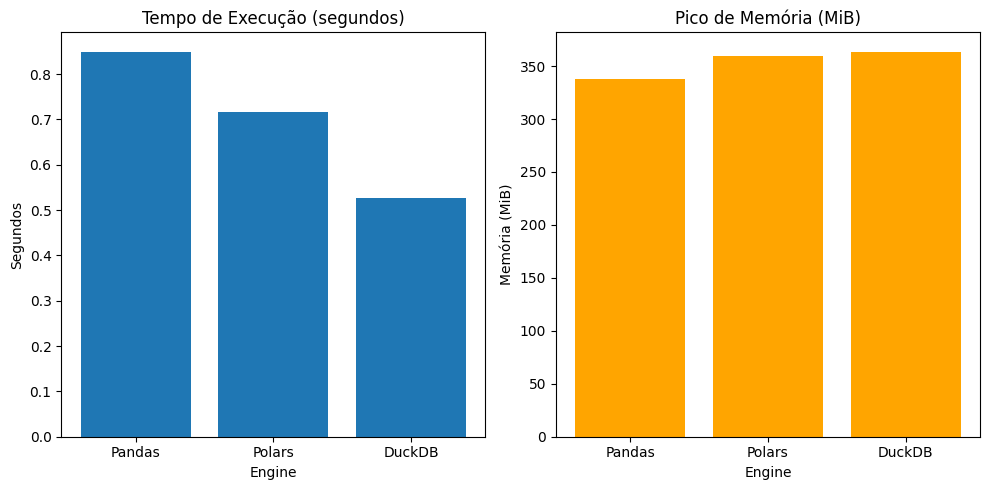

In [10]:
import matplotlib.pyplot as plt

# Define o tamanho da figura
plt.figure(figsize=(10, 5))

# Gráfico de Tempo
plt.subplot(1, 2, 1)
plt.bar(benchmark_df['engine'], benchmark_df['tempo'])
plt.title('Tempo de Execução (segundos)')
plt.ylabel('Segundos')
plt.xlabel('Engine')

# Gráfico de Memória
plt.subplot(1, 2, 2)
plt.bar(benchmark_df['engine'], benchmark_df['memoria'], color='orange')
plt.title('Pico de Memória (MiB)')
plt.ylabel('Memória (MiB)')
plt.xlabel('Engine')

# Layout bonitinho
plt.tight_layout()
plt.show()